In [1]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from statistics import mode

In [2]:
class Node():
    # Variables in this class will be
    # 1. type: Type of the node (Decision , Label).
    # 2. attribute: If this is a decison node, then attribute contains the name of the attribute that this node will be testing.
    # 3. Possible values: For the given attribute value, this list will have all possible values of the attribute.
    # 4. Child Node Links: This is a collection of the child nodes from this node.
    # 5. Label: If the type of the node is label, then this variable will hold the name of the variable.
    def __init__(self):
        self.node_type = None
        self.attribute = None
        self.values = None
        self.children = {}
        self.label = None

In [3]:
class Tree:
    # Variables in this class will be 
    # 1. root_node: Node
    # 2. minimal_gain: float, the minimal information gain, below which the tree will stop growing.
    # 3. maximal_depth: int, the maximal depth of a tree, above which the tree will stop growing.
    #
    # Methods in this class will be
    # 1. train(): Train the tree
    # 2. predict(): Test the tree
    
    def __init__(self, minimal_gain, maximal_depth, minimal_size, use_minimal_gain, use_maximal_depth, use_minimal_size):
        self.root_node = Node()
        self.minimal_gain = minimal_gain
        self.maximal_depth = maximal_depth
        self.minimal_size = minimal_size
        
        self.use_minimal_gain = use_minimal_gain
        self.use_maximal_depth = use_maximal_depth
        self.use_minimal_size = use_minimal_size
        
    # Entropy function
    def get_entropy(self, dataset):
        probability_vector = dataset['target'].value_counts().div(len(dataset))
        entropy = probability_vector.apply(lambda x: -(x*np.log2(x))).sum()
        return entropy

    # Information Gain Function
    def information_gain(self, dataset, attributes, attributes_dict):
        info_gain_list = []
        main_entropy = self.get_entropy(dataset)
        for col in attributes:
            threshold = None

            if attributes_dict[col]=="NUMERICAL":
                avg_entropy = 0
                
                threshold = dataset[col].mean()
                
                sub_dataset_len = len(dataset[dataset[col]<=threshold])
                entropy = self.get_entropy(dataset[dataset[col]<=threshold])
                avg_entropy += (sub_dataset_len/len(dataset))*entropy
                
                sub_dataset_len = len(dataset[dataset[col]>threshold])
                entropy = self.get_entropy(dataset[dataset[col]>threshold])
                avg_entropy += (sub_dataset_len/len(dataset))*entropy

            else:
                values = data[col].unique()
                avg_entropy = 0
                for val in values:
                    sub_dataset_len = len(dataset[dataset[col]==val])
                    entropy = self.get_entropy(dataset[dataset[col]==val])
                    avg_entropy += (sub_dataset_len/len(dataset))*entropy

            info_gain = main_entropy - avg_entropy
            info_gain_list.append([col, info_gain, threshold])
        info_gain_list = pd.DataFrame(info_gain_list,columns=['Attribute','Information_Gain', 'Threshold'])
        return info_gain_list.sort_values(by=['Information_Gain'],ascending=False)  
    
    def train(self, dataset, attributes, attributes_dict, depth_level):
        node = Node()
        target_labels = dataset.value_counts(subset=['target'],sort=True)
        
        # Termination condition
        if target_labels.iloc[0] == len(dataset):
            node.node_type='LEAF'
            node.label = target_labels.idxmax()[0]
            return node
        
        # Checking the depth of the tree everytime, if the depth equals the maximal depth, stop the tree from growing further.
        if self.use_maximal_depth and depth_level >= self.maximal_depth:
            node.node_type='LEAF'
            node.label = target_labels.idxmax()[0]
            return node
        
        # Checking the size of the split, if the split is less than the defined value, stop the tree from growing further.
        if self.use_minimal_size and len(dataset)<self.minimal_size:
            node.node_type='LEAF'
            node.label = target_labels.idxmax()[0]
            return node

        info_gain_list = self.information_gain(dataset, attributes, attributes_dict) # Dataset and attribute lists are changing every time, should we take original one every time.
        best_attribute = info_gain_list.iloc[0]['Attribute']
        threshold = info_gain_list.iloc[0]['Threshold']
        
        # Checking the gain from the best attribute, if this is less then a threshold, then set the node as leaf node and return the majority class.
        best_attribute_info_gain = info_gain_list.iloc[0]['Information_Gain']
        if self.use_minimal_gain and best_attribute_info_gain < self.minimal_gain:
            node.node_type='LEAF'
            node.label = target_labels.idxmax()[0]
            return node
    
        node.node_type='DECISION'
        node.attribute = best_attribute
        node.values = data[best_attribute].unique()
        
        # Selecting sq root number of random attributes
        sub_attributes = np.random.choice(attributes, int(math.sqrt(len(attributes))))
        
        if attributes_dict[best_attribute] == "CATEGORICAL":
            for value in node.values:
                sub_dataset = dataset[dataset[best_attribute]==value]

                if sub_dataset.empty:
                    node.attribute = None
                    node.values = None

                    node.node_type='LEAF'
                    node.label = target_labels.idxmax()[0]

                else:            
                    sub_decision_tree = self.train(sub_dataset,sub_attributes, attributes_dict, depth_level+1)
                    node.children[value] = sub_decision_tree

        else:
            sub_dataset = dataset[dataset[best_attribute]<=threshold]
            if sub_dataset.empty:
                node.attribute = None
                node.values = None

                node.node_type='LEAF'
                node.label = target_labels.idxmax()[0]

            else:
                node.threshold = threshold
                sub_decision_tree = self.train(sub_dataset,sub_attributes, attributes_dict, depth_level+1)
                node.children['LTE'] = sub_decision_tree
                
            sub_dataset = dataset[dataset[best_attribute]>threshold]
            if sub_dataset.empty:
                node.attribute = None
                node.values = None

                node.node_type='LEAF'
                node.label = target_labels.idxmax()[0]

            else:
                node.threshold = threshold
                sub_decision_tree = self.train(sub_dataset,sub_attributes, attributes_dict, depth_level+1)
                node.children['GT'] = sub_decision_tree
                    
        return node
        
    def generate_tree(self, dataset, attributes, attributes_dict):
        self.root_node = self.train(dataset, attributes, attributes_dict, depth_level=0)
          
    def predict_target(self, node, instance, attributes_dict):
        if node.node_type =='LEAF':
            return node.label
        best_attribute = node.attribute
        if attributes_dict[best_attribute] == "CATEGORICAL":
            best_attribute_value = instance[best_attribute]
            next_node = node.children[best_attribute_value]
        else:
            if instance[best_attribute] <= node.threshold:
                next_node = node.children['LTE']
            else:
                next_node = node.children['GT']
        return self.predict_target(next_node, instance, attributes_dict)
    

In [4]:
def generate_k_fold_valdition_sets(dataset, folds):
    labels = dataset['target'].unique()
    proportions = dataset['target'].value_counts().div(folds)

    label_proportions_dict = {}

    k_fold_datasets = []

    for label in labels:
        label_proportions_dict[label] = dataset[dataset['target']==label]
        
    for i in range(folds):

        dataset = pd.DataFrame()

        for label in labels:
            if i == folds-1:
                sub_dataset = label_proportions_dict[label]
            else:
                sub_dataset = label_proportions_dict[label].sample(n=int(proportions[label]))
            label_proportions_dict[label] = label_proportions_dict[label].drop(sub_dataset.index)

            dataset = pd.concat([dataset, sub_dataset])
            
        dataset = dataset.sample(frac=1)
        k_fold_datasets.append(dataset)

    return k_fold_datasets

In [5]:
class RandomForest:
    def __init__(self, k, dataset, attributes_dict):
        self.k = k
        self.trees = []

        self.dataset = dataset
        self.attributes = np.array(self.dataset.columns.drop('target'))
        self.attributes_dict = attributes_dict
        
    def generate_bootstrap_datasets(self):
        bootstrap_datasets = []

        for i in range(self.k):
            temp = self.dataset.sample(frac = random.uniform(0.1,1))
            bootstrap_dataset = temp.sample(frac=(len(self.dataset)/len(temp)), replace=True)
            bootstrap_datasets.append(bootstrap_dataset)

        return bootstrap_datasets
    
    def train(self, minimal_gain, maximal_depth, minimal_size, use_minimal_gain, use_maximal_depth, use_minimal_size):
        self.bootstrap_datasets = self.generate_bootstrap_datasets()
        
        for i in range(self.k):
            tree = Tree(minimal_gain, maximal_depth, minimal_size, use_minimal_gain, use_maximal_depth, use_minimal_size)
            tree.generate_tree(self.bootstrap_datasets[i],self.attributes, self.attributes_dict)
            
            self.trees.append(tree)
    
    def predict_class(self, instance):
        predictions = []
        
        for i in range(self.k):
            predicted_class = self.trees[i].predict_target(self.trees[i].root_node, instance, self.attributes_dict)
            predictions.append(predicted_class)
        
        return(mode(predictions))

In [6]:
data = pd.read_csv('hw3_wine.csv',sep='\t')
data = data.rename(columns={"# class": "target"})
attributes = np.array(data.columns.drop('target'))
attributes_dict = {}
for col in attributes:
    attributes_dict[col] = "NUMERICAL"

minimal_gain = 0.1
use_minimal_gain = False

minimal_size = 3
use_minimal_size = True

maximal_depth = 5
use_maximal_depth = True

k_folds = 10
# n_tree = 10

In [7]:
def get_f_score(beta, precision, recall):
    score = ( (1+(beta**2))*(precision*recall) )/( ((beta**2)*precision)+recall )
    return score

In [8]:
n_tree_values = [1,5,10,20,30,40,50]    

accuracies = []
precisions = []
recalls = []
f1_scores = []

for n_tree in n_tree_values:
    
    k_fold_datasets = generate_k_fold_valdition_sets(data, k_folds)

    accuracy_list = []
    precision_list = []
    recall_list = []
    
    for i in range(k_folds):
        indices = list(range(k_folds))
        indices.remove(i)

        train_set = pd.DataFrame()
        test_set = pd.DataFrame()

        for j in indices:
            train_set = pd.concat([train_set,k_fold_datasets[j]])
        test_set = k_fold_datasets[i] 
        forest = RandomForest(n_tree, train_set, attributes_dict)
        forest.train(minimal_gain, maximal_depth, minimal_size, use_minimal_gain, use_maximal_depth, use_minimal_size)

        confusion = [[0,0,0],[0,0,0],[0,0,0]]
        
        for index, instance in test_set.iterrows():
            predicted_class = forest.predict_class(instance)
            confusion[int(instance['target'])-1][predicted_class-1]+=1
        
        accuracy = (confusion[0][0] + confusion[1][1] + confusion[2][2])/len(test_set)
        
        try:
            p0 =  confusion[0][0]/(confusion[0][0]+confusion[1][0]+confusion[2][0])
        except:
            p0 = 1
        try:
            p1 =  confusion[1][1]/(confusion[0][1]+confusion[1][1]+confusion[2][1])
        except:
            p1 = 1
        try:
            p2 =  confusion[2][2]/(confusion[0][2]+confusion[1][2]+confusion[2][2])
        except:
            p2 = 1
        
        try:
            r0 =  confusion[0][0]/(confusion[0][0]+confusion[0][1]+confusion[0][2])
        except:
            r0 = 1
        try:
            r1 =  confusion[1][1]/(confusion[1][0]+confusion[1][1]+confusion[1][2])
        except:
            r1 = 1
        try:
            r2 =  confusion[2][2]/(confusion[2][0]+confusion[2][1]+confusion[2][2])
        except:
            r2 = 1

        accuracy_list.append(accuracy)
        precision_list.append((p0+p1+p2)/3)
        recall_list.append((r0+r1+r2)/3)
    
    accuracy_list = np.array(accuracy_list)
    precision_list = np.array(precision_list)
    recall_list = np.array(recall_list)

    mean_accuracy = np.mean(accuracy_list)
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)
    f1_score = get_f_score(1,mean_precision, mean_recall)

    accuracies.append(mean_accuracy)
    precisions.append(mean_precision)
    recalls.append(mean_recall)
    f1_scores.append(f1_score)
    
    print('-----------------Trees - {}---------------------'.format(n_tree))

    print('Accuracy: {}'.format(mean_accuracy))
    print('Precision: {}'.format(mean_precision))
    print('Recall: {}'.format(mean_recall))
    print('F1-Score: {}'.format(f1_score))    
    print()

-----------------Trees - 1---------------------
Accuracy: 0.7485294117647059
Precision: 0.7977501202501202
Recall: 0.7483730158730157
F1-Score: 0.7722731126081488

-----------------Trees - 5---------------------
Accuracy: 0.8819852941176471
Precision: 0.8958189033189032
Recall: 0.8869444444444443
F1-Score: 0.891359585694699

-----------------Trees - 10---------------------
Accuracy: 0.9161764705882354
Precision: 0.9328968253968254
Recall: 0.91734126984127
F1-Score: 0.9250536573027245

-----------------Trees - 20---------------------
Accuracy: 0.9408088235294118
Precision: 0.9479232804232804
Recall: 0.9467460317460317
F1-Score: 0.9473342903441969

-----------------Trees - 30---------------------
Accuracy: 0.9658088235294118
Precision: 0.9718650793650794
Recall: 0.9701190476190475
F1-Score: 0.9709912785662713

-----------------Trees - 40---------------------
Accuracy: 0.9503676470588236
Precision: 0.9519047619047619
Recall: 0.9592063492063494
F1-Score: 0.9555416073406107

---------------

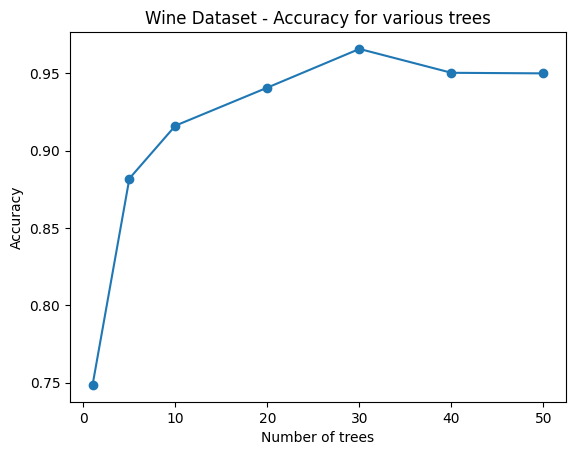

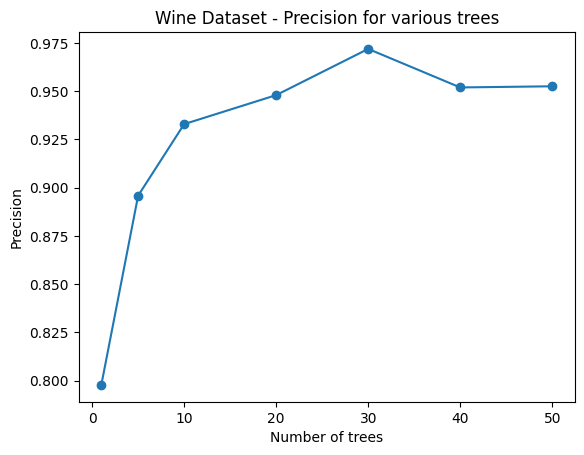

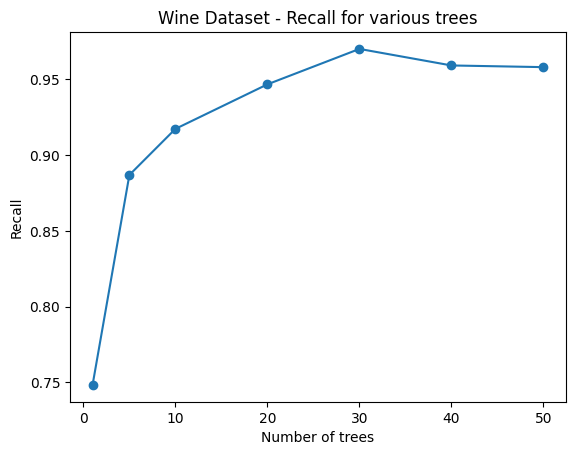

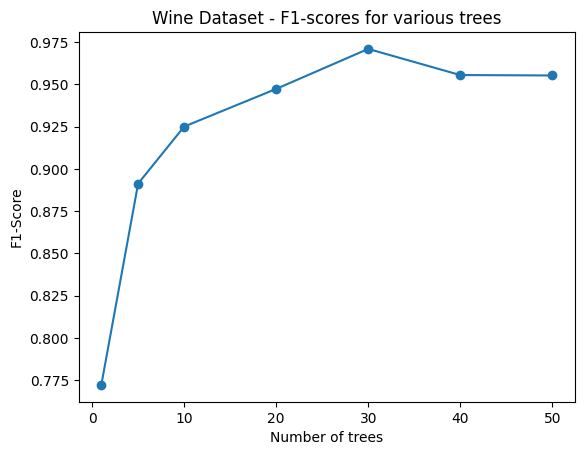

In [11]:
plt.plot(n_tree_values, accuracies, marker='o')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Wine Dataset - Accuracy for various trees')  
plt.show()

plt.plot(n_tree_values, precisions, marker='o')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.title('Wine Dataset - Precision for various trees')  
plt.show()

plt.plot(n_tree_values, recalls, marker='o')
plt.xlabel('Number of trees')
plt.ylabel('Recall')
plt.title('Wine Dataset - Recall for various trees')  
plt.show()

plt.plot(n_tree_values, f1_scores, marker='o')
plt.xlabel('Number of trees')
plt.ylabel('F1-Score')
plt.title('Wine Dataset - F1-scores for various trees')  
plt.show()